In [ ]:
# !pip install bertopic

In [ ]:
# 사용할 라이브러리와 패키지를 Import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bertopic import BERTopic

# Pyplot의 스타일 설정
plt.style.use('fivethirtyeight')

In [ ]:
# 데이터셋 불러오기
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/sample_submission.csv')

In [ ]:
# Train dataset
df_train.sample(5)

,ID,text,target,url,date
1975,ynat-v1_train_01975,중국 핵무기는 위협 안 돼…中 INF 참여 요구 거부,4,https://news.naver.com/main/read.nhn?mode=LS2D...,2019.02.18. 오전 11:00
1309,ynat-v1_train_01309,선두 넘보지 마…이재영의 흥국생명 GS칼텍스 완파종합,5,https://sports.news.naver.com/news.nhn?oid=001...,2019.02.13 21:31
2352,ynat-v1_train_02352,朴대통령 빨리 3당 대표 만나겠다…국면전환 개각 어렵다종합,6,https://news.naver.com/main/read.nhn?mode=LS2D...,2016.04.26. 오후 6:12
1574,ynat-v1_train_01574,산업은행 현대상선 해운동맹 제외돼도 계속 정상화 지원종합,1,https://news.naver.com/main/read.nhn?mode=LS2D...,2016.05.13. 오후 3:45
5903,ynat-v1_train_05903,홍콩 시위 소강상태…24일 구의원 선거에 기대 걸기도,4,https://news.naver.com/main/read.nhn?mode=LS2D...,2019.11.21. 오후 7:54


In [ ]:
# Test dataset
df_test.head(5)

,ID,text,url,date
0,ynat-v1_dev_00000,제임스 부상 레이커스 성탄매치서 골든스테이트에 완승종합,https://sports.news.naver.com/news.nhn?oid=001...,2018.12.26 15:16
1,ynat-v1_dev_00001,프랑스 극우정치인 르펜 노란 조끼 덕에 승승장구,https://news.naver.com/main/read.nhn?mode=LS2D...,2019.01.17. 오후 8:04
2,ynat-v1_dev_00002,대통령개헌안 ⑥토지공개념 명시…개발이익환수·부동산과세 강화 전망종합,https://news.naver.com/main/read.nhn?mode=LS2D...,2018.03.21. 오후 1:09
3,ynat-v1_dev_00003,의사 살해 환자 경찰서 나와 법원으로,https://news.naver.com/main/read.nhn?mode=LS2D...,2019.01.02. 오후 2:47
4,ynat-v1_dev_00004,이란 최고지도자 유럽 맹비난…핵합의 미이행 뻔뻔하고 오만,https://news.naver.com/main/read.nhn?mode=LS2D...,2019.07.16. 오후 8:11


In [ ]:
# Submission dataset
submission.head(5)

,ID,target
0,ynat-v1_dev_00000,0
1,ynat-v1_dev_00001,0
2,ynat-v1_dev_00002,0
3,ynat-v1_dev_00003,0
4,ynat-v1_dev_00004,0


In [ ]:
# 각 데이터셋의 shape을 출력
print(f'Train dataset shape: {df_train.shape}')
print(f'Test dataset shape: {df_test.shape}')

Train dataset shape: (7000, 5)
Test dataset shape: (47785, 4)


7천 개의 데이터를 학습하여 4만 8천여 개의 헤드라인을 주제 별로 분류해야 합니다.

In [ ]:
# 데이터셋의 데이터 타입 확인
print(f"{'-'*10}Train dataset{'-'*10}")
print(df_train.info())
print(f"{'*'*35}")
print(f"{'*'*35}")
print(f"{'-'*10}Train dataset{'-'*10}")
print(df_test.info())

----------Train dataset----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      7000 non-null   object
 1   text    7000 non-null   object
 2   target  7000 non-null   int64 
 3   url     7000 non-null   object
 4   date    7000 non-null   object
dtypes: int64(1), object(4)
memory usage: 273.6+ KB
None
***********************************
***********************************
----------Train dataset----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47785 entries, 0 to 47784
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      47785 non-null  object
 1   text    47785 non-null  object
 2   url     47785 non-null  object
 3   date    47785 non-null  object
dtypes: object(4)
memory usage: 1.5+ MB
None


'date' 피쳐의 타입이 단순히 str으로 되어 있기 때문에, 앞으로 해당 컬럼을 보다 수월하게 핸들링하기 위해서 pandas의 datetime 객체로 변경해줍니다.

In [ ]:
# 'date' 컬럼에서 년, 월, 일만 추출하여 datetime 객체로 변환
def convert_to_date_only(date_str):
    date_str = date_str[:10] # 시간 제외
    return pd.to_datetime(date_str)

In [ ]:
# 'date' 피쳐의 포맷을 pandas.datetime으로 변경
# For train set
df_train['datetime'] = df_train['date'].apply(convert_to_date_only)
df_test['datetime'] = df_test['date'].apply(convert_to_date_only)

<Axes: xlabel='target', ylabel='count'>

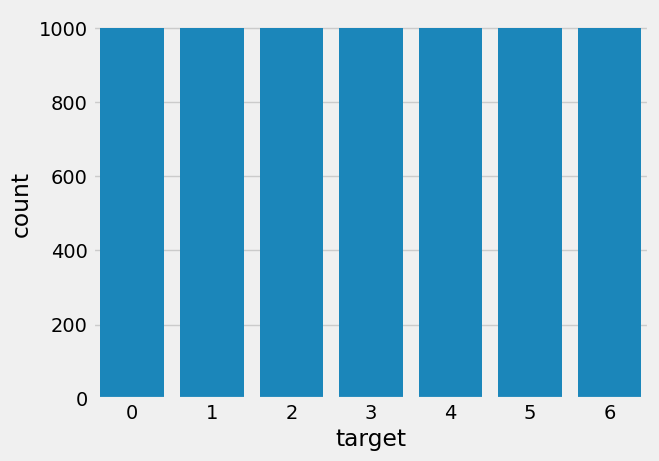

In [ ]:
sns.countplot(data=df_train, x='target')

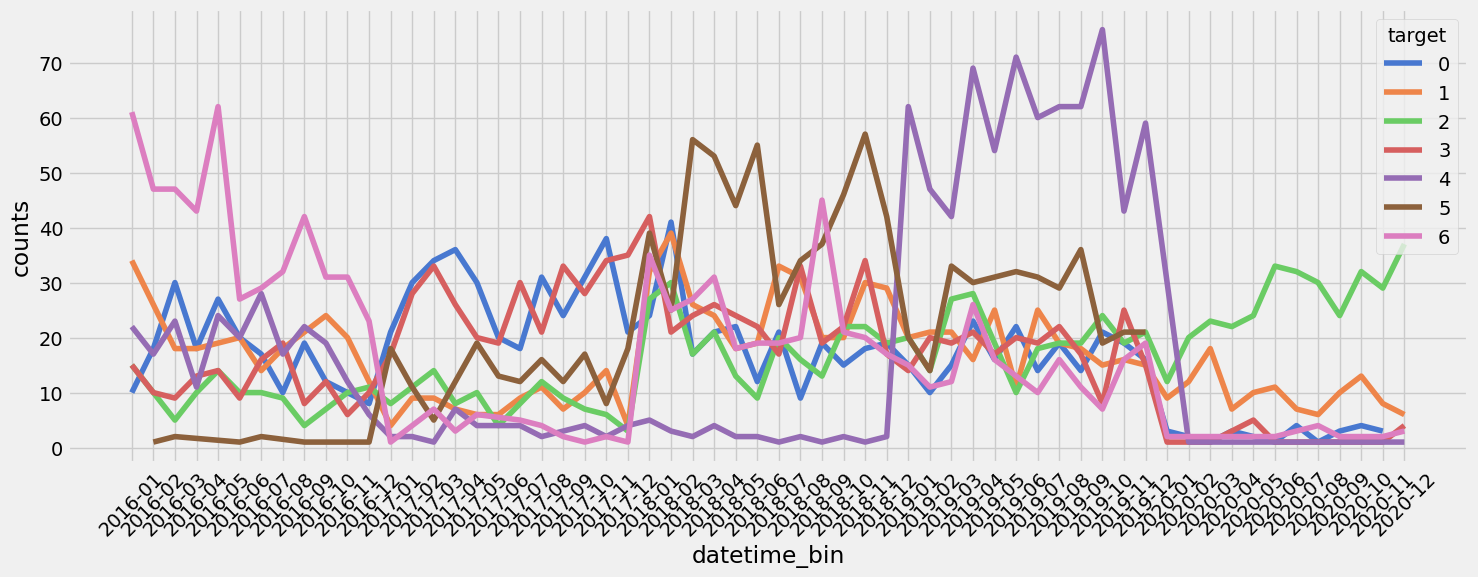

In [ ]:
df_train['datetime_bin'] = df_train['datetime'].dt.to_period('M')  # Change 'D' to your desired bin (e.g., 'H' for hour, 'W' for week)

# Data Aggregation
df_grouped = df_train.groupby(['datetime_bin', 'target']).size().reset_index(name='counts')
df_grouped['datetime_bin'] = df_grouped['datetime_bin'].astype(str)

# Plotting with Seaborn
plt.figure(figsize=(15, 6))
sns.lineplot(data=df_grouped, x='datetime_bin', y='counts', hue='target', palette='muted')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# For train
topic_model = BERTopic(embedding_model='snunlp/KR-SBERT-V40K-klueNLI-augSTS')
timestamps = df_train['datetime']
texts = df_train['text']
targets = df_train['target']
topics, probs = topic_model.fit_transform(texts)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.02k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/336k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/967k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
topics_over_time = topic_model.topics_over_time(texts, timestamps, nr_bins=20)
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10)

In [ ]:
topics_per_class = topic_model.topics_per_class(texts, classes=targets)
topic_model.visualize_topics_per_class(topics_per_class, top_n_topics=10)

In [ ]:
# For test
topic_model = BERTopic(embedding_model='snunlp/KR-SBERT-V40K-klueNLI-augSTS')
timestamps = df_test['datetime']
texts = df_test['text']
topics, probs = topic_model.fit_transform(texts)

In [ ]:
topics_over_time = topic_model.topics_over_time(texts, timestamps, nr_bins=20)
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=20)